# Introduction

This notebook will explore the thought process of features that can be used to ameliorate the gait feature pipeline. In ingesting signals from gait data (walking motion) there are a lot of variability that could occur, such as how a test subject can stop doing their test in the middle of test, doing a turn or rotation, which might cause biases towards the feature computation. Therefore this notebook will explore how we can segment the walking signal data into 3 separate sequence as <b> resting, walking, and rotation </b>.

In [42]:
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pdkit.utils import (butter_lowpass_filter)
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("dark")
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## log in to synapse for querying data in SageBionetworks ## 
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [3]:
path_data = query.get_walking_synapse_table(syn, 
                                            "syn12514611", 
                                            "MPOWER_V2", 
                                            healthCodes = ["1fa674e9-2c49-4260-83f0-681ace2a5125", # parkinson
                                                          "c52432c0-754b-4490-b131-9684da102f6c", # control 
                                                          "e8167893-1b3a-4c71-94f4-5b3cb9b52165", # control
                                                          "f80e44ed-ce6f-4aff-8a6a-cfa74c823f6a"]) # parkinson

Querying MPOWER_V2 Data


INFO:synapseclient_default:Downloading 12 files, 284 cached locally


In [170]:
## package call ##
gf = gproc.GaitFeaturize()

In [171]:
## helper function ## 
def plot_rotation(accel_data, rotation_data):
    fig, axes = plt.subplots(2, 1)
    
    
    resampled_rotation = gf._resample_signal(rotation_data)
    resampled_accel = gf._resample_signal(accel_data)

    filtered_rotation = resampled_rotation.copy()
    filtered_rotation["y"] = butter_lowpass_filter(data = resampled_rotation["y"],
                                                    sample_rate = 100,
                                                    cutoff      = 2, 
                                                    order       = 2) 

    filtered_rotation["y"].plot(grid = True, ax = axes[0], figsize = (20,8))
    axes[0].set_title("Low-Passs-Filtered Rotation Rate Data in y-axial Orientation")
    axes[0].axhline(0, linestyle = "-.", color = "r")

    resampled_accel["y"].plot(grid = True, ax = axes[1], figsize = (20,8))
    axes[1].set_title("User Acceleration Data in y-axial Orientation")
    axes[1].axhline(0, linestyle = "-.", color = "r")
    
    rotation_dict = gf.get_gait_rotation_info(resampled_rotation)
    periods = [v["period"] for k,v in rotation_dict.items()]

    for period in periods:

        index_start = period[0]
        index_end = period[1]

        filtered_rotation = resampled_rotation.copy()
        filtered_rotation["y"] = butter_lowpass_filter(data = resampled_rotation["y"],
                                                        sample_rate = 100,
                                                        cutoff      = 2, 
                                                        order       = 2) 

        axes[0].axvline(filtered_rotation.index[index_start], color = "orange")
        axes[0].axvline(filtered_rotation.index[index_end], color = "orange")


        axes[1].axvline(resampled_accel.index[index_start], color = "orange")
        axes[1].axvline(resampled_accel.index[index_end], color = "orange")

    fig.tight_layout()
    fig.show()

## Automatic Rotation Detection

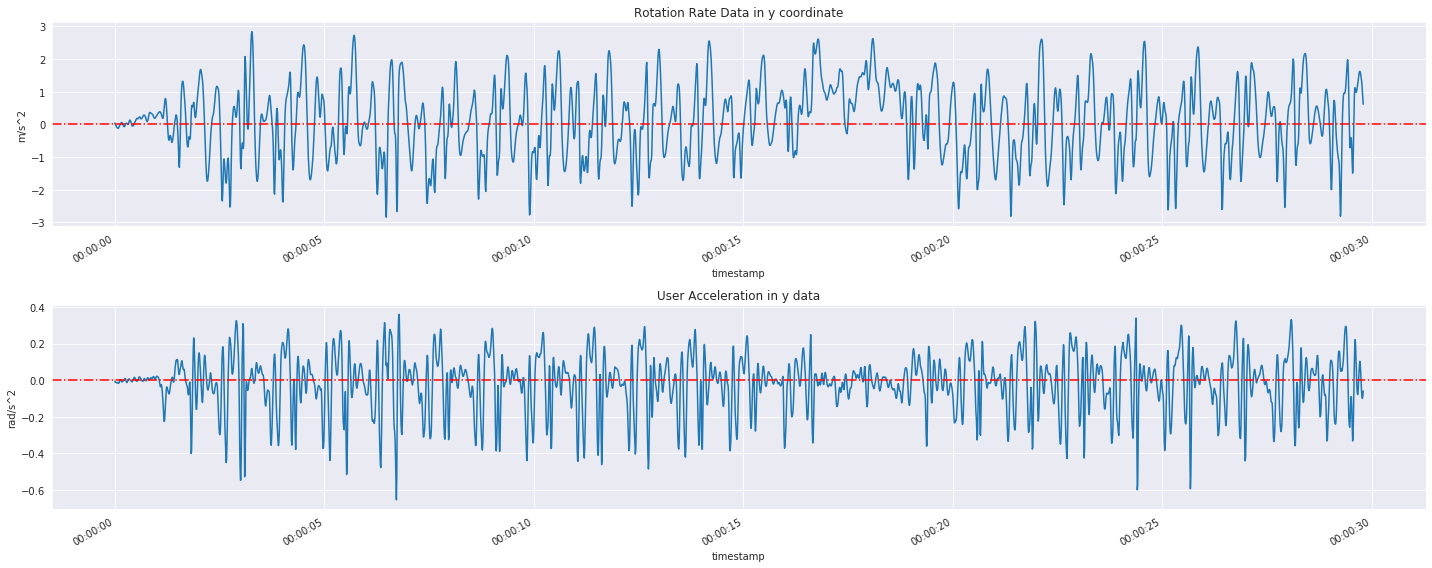

In [172]:
filepath = path_data["walk_motion.json_pathfile"].iloc[2]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")

fig, axes = plt.subplots(2, 1)

gyro["y"].plot(grid = True, ax = axes[0], figsize = (20,8))
axes[0].set_title("Rotation Rate Data in y coordinate")
axes[0].set_ylabel("m/s^2")
axes[0].axhline(0, linestyle = "-.", color = "r")

accel["y"].plot(grid = True, ax = axes[1], figsize = (20,8))
axes[1].set_title("User Acceleration in y data")
axes[1].set_ylabel("rad/s^2")
axes[1].axhline(0, linestyle = "-.", color = "r")

fig.tight_layout()
fig.show()

### a. One Rotation Demo

From the time-series data above, we can see that there are is a huge amount of increase on approximately the <b> 17th second </b>, ending on around the <b> 20th second </b>. This is an indication that a person is doing a rotational movement during the mPower Walking test. Thus, our goal is to isolate this sequence, so that we can take in some rotational features, as well as an unbiased features on the walking tests.

Per the reseach paper published by [name], to recognize rotational movement, here are the steps that we are going to implement for our own gait signal QC pipeline:
<b>
- Apply low-pass filter into the signal data
- Detect zero crossing occurences on the time-series data, and separate the data
- On each period separated by the zero crossing, calculate the AUC of the period to get radians
- Using AUC during the particular period, multiply by duration (radians.secs)
- A threshold will be done distinguish rotation. A particular metrics established by the research paper shows that the AUC * duration during a period of zero crossing that is above 2 is a good metric for detecting a user rotation. 
</b>

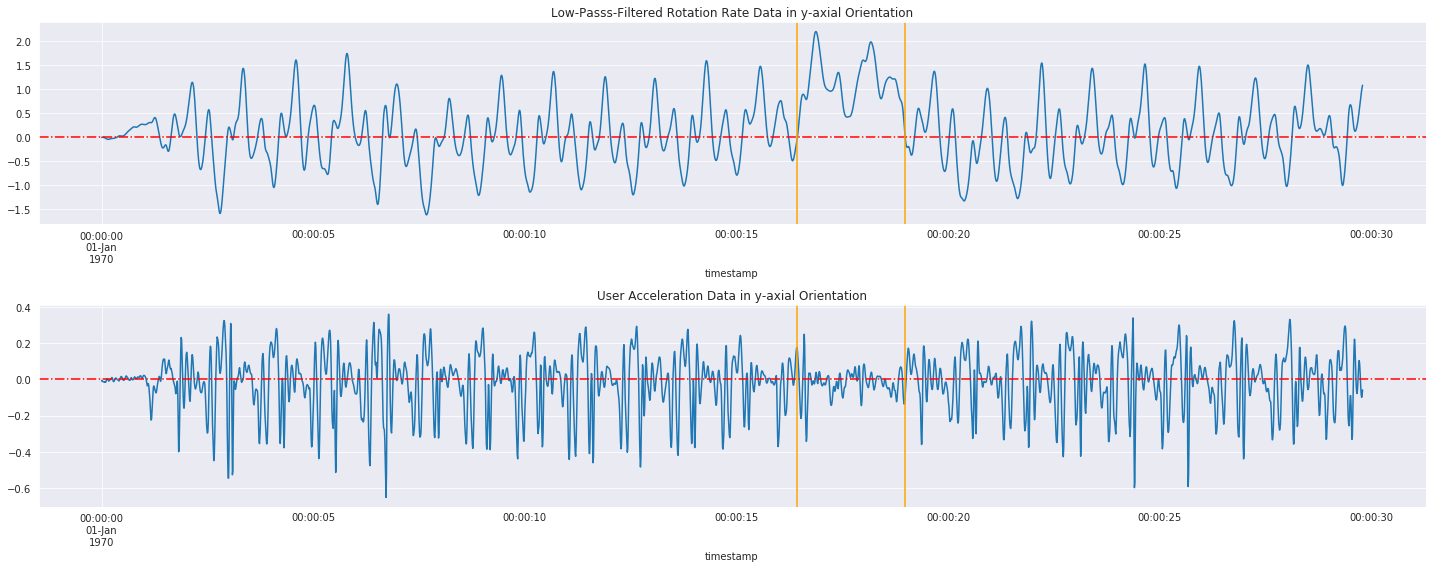

In [173]:
filepath = path_data["walk_motion.json_pathfile"].iloc[2]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")
plot(accel,gyro)

As seen from this signal visualization above, notice the abnormalities that occured in the signal acceleration plot. During a rotation sequence, most of the user acceleration magnitude suddenly gets lower in comparison to the cyclical pattern that it demonstrated several seconds prior. 

### b. Multiple Rotation Demo

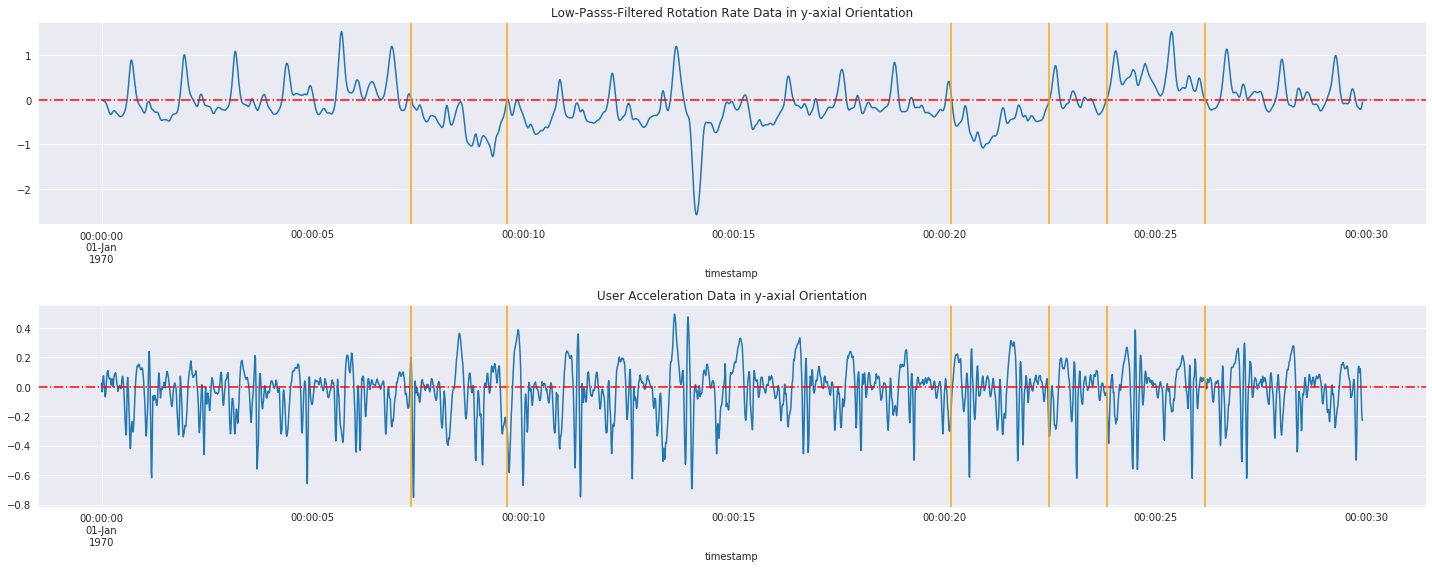

In [174]:
filepath = path_data["walk_motion.json_pathfile"].iloc[50]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")
plot(accel,gyro)

As seen from the picture above, we are able to retrieve 3 rotation sequence from this data, although not as apparent as the ones from the first demo, it might be caused due to the amount of radians being done by the users, the users might just did little turns, or it might be the computation itself that is oversensitive towards any kind of body turns. This might be a thing that we can improve in future implementations. 

## 2. Segmenting Rest Motion (NOT IMPLEMENTED YET ON PIPELINE)

### a. Ideation

In [175]:
def annotate_consecutive_zeros(data, feature):
    """
    Function to annotate consecutive zeros in a dataframe
    Args:
        `data`    : dataframe
        `feature` : feature to assess on counting consecutive zeros

    returns:
        A new column-series of data with counted consecutive zeros (if available)
    """
    step_shift_measure = data[feature].ne(data[feature].shift()).cumsum()
    counts = data.groupby(['recordId', step_shift_measure])[feature].transform('size')
    data['consec_zero_cadence'] = np.where(data[feature].eq(0), counts, 0)
    return data

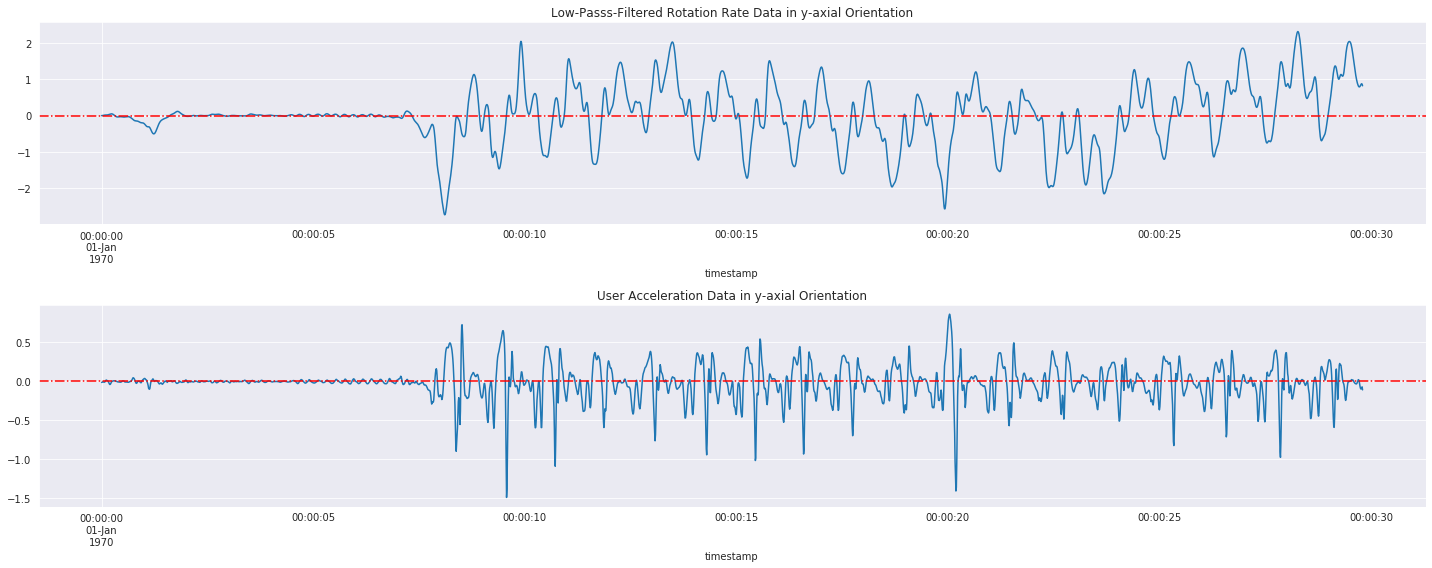

In [176]:
filepath = path_data["walk_motion.json_pathfile"].iloc[0]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")
plot(accel,gyro)

In this graph we can see that the first 7 seconds is a clear indication that user is not doing the test like they are supposed to, which is a QC that we might require whenever we are trying to assess any features that uses heel strikes/steps as their basis of analysis. Having this QC might be useful as well to infer passive data filters to see whether our users are actually walking.

In [177]:
data = pd.DataFrame(gf.run_gait_feature_pipeline(filepath))
data[[feat for feat in data.columns if "cadence" in feat]].head(10)

,AA_cadence,x_cadence,y_cadence,z_cadence
0,0.195680,0.391359,0.587039,0.195680
1,0.000000,1.565435,0.978397,1.565435
2,0.000000,2.739509,0.000000,1.956792
3,0.000000,0.000000,1.174074,0.195679
4,0.000000,0.391358,0.391358,0.391358
5,0.000000,0.391358,0.587036,0.782715
6,0.587036,0.782715,0.978393,1.174072
7,0.391357,1.174071,1.174071,1.369750
8,0.587035,1.174070,1.174070,1.565427
9,0.782713,1.174069,0.978391,1.369747


From the dataframe above, the cadence assessed from the resultant signal is zeroes out if a user is not doing their tests properly. Let's Try this to a balanced test users and see whether our hypothesis holds true.

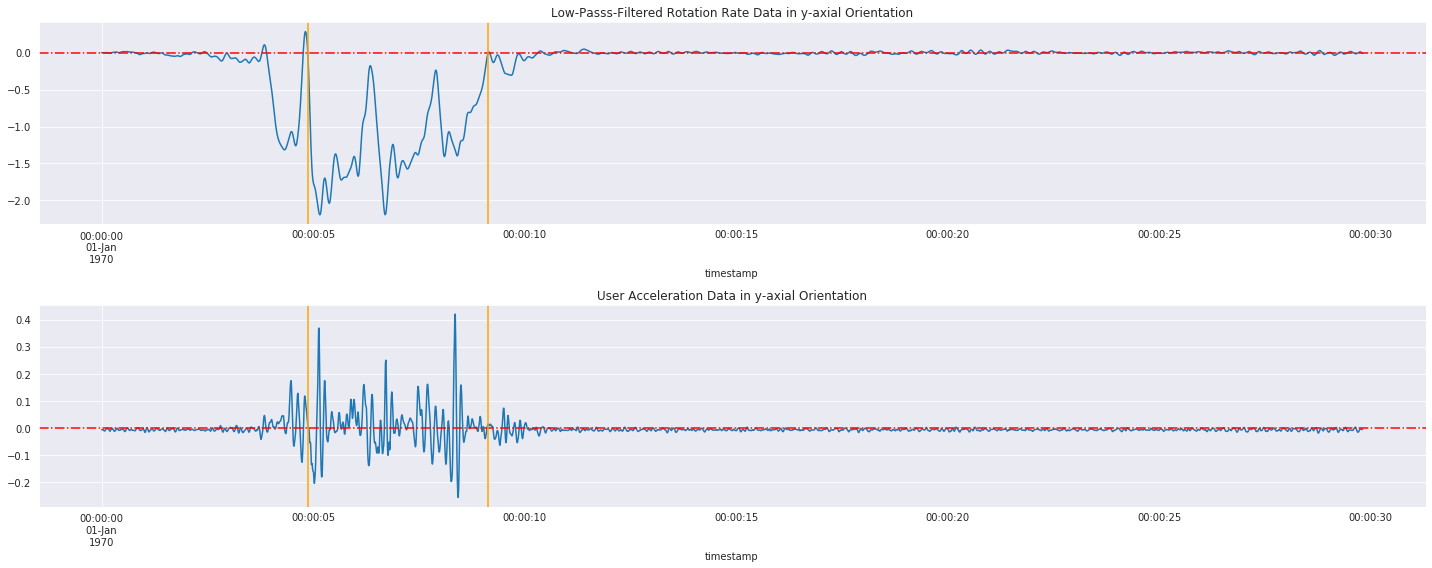

In [180]:
filepath = path_data["balance_motion.json_pathfile"].iloc[1]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")
plot_rotation(accel,gyro)

In [181]:
data = pd.DataFrame(gf.run_gait_feature_pipeline(filepath))
data[[feat for feat in data.columns if ("cadence" in feat) 
      | ("rotation_omega" in feat) | ("window" in feat)]].head(10)

,AA_cadence,rotation_omega,window,window_size,x_cadence,y_cadence,z_cadence
0,0.000000,NaN,window_1,4.879262,0.409898,0.409898,0.000000
1,0.704964,1.230221,window_2,4.255536,0.704964,0.939952,0.469976
2,0.000000,NaN,window_3,5.110686,0.195668,0.195668,0.587005
3,0.000000,NaN,window_4,5.110691,1.174009,0.000000,0.000000
4,0.000000,NaN,window_5,5.110695,0.782672,0.000000,1.956681
5,0.000000,NaN,window_6,5.110700,0.782672,0.000000,2.543683
6,0.000000,NaN,window_7,5.100644,0.784215,0.000000,2.352644
7,0.000000,NaN,window_8,5.110711,0.782670,0.000000,2.543677
8,0.000000,NaN,window_9,5.110718,0.000000,0.000000,2.739341
9,0.000000,NaN,window_10,5.110725,0.000000,0.000000,3.130672


This subset shows that during a balance test, we can see that the algorithm are able to detect the rotation during the balance test (which happened as a prompt for users), however, in terms of cadence in the resultant axis and the y-axis after the rotation, we can see that the data suddenly goes back to zero, which can happen to the filter of extremely low variance and a lack of zero crossing of the signal data itself (a metric that is useful for detecting heel strikes). Thus, this filter will be useful for our analysis as if we do not filter the zero cadence period, we might underestimate the cadence of a certain user after we aggregate our data based on each users.

### b. Filtering Consecutive Zero Cadence

In [182]:
data["recordId"] = "198459e0-6066-45ec-ade5-18b55c10cbb8"
annot = annotate_consecutive_zeros(data, "y_cadence")[["y_cadence", "consec_zero_cadence"]]
annot

,y_cadence,consec_zero_cadence
0,0.409898,0
1,0.939952,0
2,0.195668,0
3,0.000000,15
4,0.000000,15
5,0.000000,15
6,0.000000,15
7,0.000000,15
8,0.000000,15
9,0.000000,15


In [183]:
## subset the zero cadence ## 

annot[annot["consec_zero_cadence"] <= 5]

,y_cadence,consec_zero_cadence
0,0.409898,0
1,0.939952,0
2,0.195668,0


As seen in the dataframe above, a function has been created to count consecutive zeros per group. Per the dataframe above 15 indicates number of consecutive cadence values. Thus, we can set a threshold towards how many consecutive zeros is acceptable for our analysis. In the other analysis notebook, we will be using a threshold of less than 5 window of consecutive zeros is acceptable (around 7 seconds of non-activity based on overlapping gait window). Optimal threshold can be assessed for any future optimization.

<b> Note: </b>

This subset filter will be implemented for assessing analysis on walking data, however this feature might be useful to keep for prediction of passive users whether if they are actually moving during data collection.